In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.simplefilter("ignore")

### I could build this into script-only, output-a-report, log-to-favourite-expt-tracking-solution, but...
<br>I still just want to iterate quickly and play around with different options, so I'll do it in a notebook

In [2]:
from trainer import CensusTrainer
import copy
import json

In [3]:
with open("census_data_col_names.json", "r") as f:
    column_names = json.load(f)
df_test = pd.read_csv("census_income_test.csv", names=column_names)
df_train = pd.read_csv("census_income_learn.csv", names=column_names)

### first pass, expressing the "feature engineering decisions" from EDA notebook into a config:

In [4]:
scale = False
rf_process_config = {}
for feat in ["age", "wage_per_hour", "capital_gains", "capital_losses", "dividends_from_stocks", "num_persons_worked_for_employer", "weeks_worked_in_year"]:
    rf_process_config[feat] = {"processor": "numeric",
                               "kwargs": {"scale": scale}}
    
rf_process_config |= {
    "class_of_worker": {"processor": "binary_flag",
                        "args": [["Not in universe"]],
                        "kwargs": {"scale": scale,
                                   "new_feature_name": "worker_not_in_class_universe"}},
    
    "detailed_industry_recode": {"processor": "binary_flag",
                                 "args": [["0"]],
                                 "kwargs": {"scale": scale,
                                            "new_feature_name": "works_in_agriculture_industry"}},
    
    "education": {"processor": "binary_flag",
                  "args": [["Bachelors degree(BA AB BS)", "Doctorate degree(PhD EdD)", "Masters degree(MA MS MEng MEd MSW MBA)", "Prof school degree (MD DDS DVM LLB JD)"]],
                  "kwargs": {"scale": scale,
                             "new_feature_name": "has_higher_education"}},
    
    "enroll_in_edu_inst_last_wk": {"processor": "binary_flag",
                                   "args": [["College or university", "High school"]],
                                   "kwargs": {"scale": scale,
                                              "new_feature_name": "still_in_education"}},
    
    "marital_stat": {"processor": "ordinal",
                     "args": [{2: ["Married-civilian spouse present"],
                               0: ["Never married"]}],
                     "kwargs": {"unspecified_categoricals_value": 1,
                                "scale": scale,
                                "new_feature_name": "never_married__other__married_(Lo-Hi)"}},
    
    "major_industry_code": {"processor": "binary_flag",
                            "args": [["Not in universe or children"]],
                            "kwargs": {"scale": scale,
                                       "new_feature_name": "child_or_industry_unknown"}},
    
    "sex": {"processor": "binary_flag",
            "args": [["Male"]],
            "kwargs": {"scale": scale,
                       "new_feature_name": "individual_is_male"}},
    
    "full_or_part_time_employment_stat": {"processor": "ordinal",
                                          "args": [{2: ["Full-time schedules"],
                                                    0: ["Children or Armed Forces", "Not in labor force"]}],
                                          "kwargs": {"unspecified_categoricals_value": 1,
                                                     "scale": scale,
                                                     "new_feature_name": "nolabour_forces_child__other__fulltime_(Lo-Hi)"}},
    
    "tax_filer_stat": {"processor": "ordinal",
                       "args": [{2: ["Joint both under 65"],
                                 0: ["Nonfiler"]}],
                       "kwargs": {"unspecified_categoricals_value": 1,
                                  "scale": scale,
                                  "new_feature_name": "non_tax_filer__other__joint_worker_filers_(Lo-Hi)"}},
    
    "detailed_household_summary_in_household": {"processor": "ordinal",
                                                "args": [{2: ["Householder"],
                                                          0: ["Child 18 or older", "Child under 18 never married", "Child under 18 ever married"]}],
                                                "kwargs": {"unspecified_categoricals_value": 1,
                                                           "scale": scale,
                                                           "new_feature_name": "child_w_parents__other__main_householder_(Lo-Hi)"}},
    
    "country_of_birth_mother": {"processor": "binary_flag",
                                "args": [["Mexico", "Puerto-Rico"]],
                                "kwargs": {"scale": scale,
                                           "new_feature_name": "mother_born_in_mexico_or_puerto_rico"}},
}

# Tried saving and reloading this, but there is a but in the code/method -- saving/loading changed keys from int to str, which causes issues. This is why we test!

### Experiment time!

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     37523
           1       0.15      0.91      0.26      2422

    accuracy                           0.69     39945
   macro avg       0.57      0.79      0.53     39945
weighted avg       0.94      0.69      0.77     39945

AUC score: 0.895


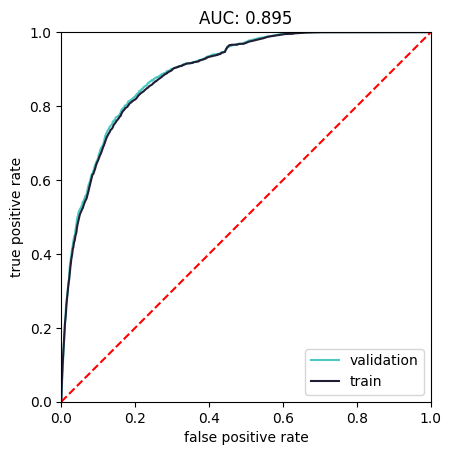

In [5]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": rf_process_config,
                        "train": {
                            "classifier": "RandomForestClassifier",
                            "n_estimators": 256,
                            "criterion": 'gini',
                            "min_weight_fraction_leaf": 0.3,
                            "max_features": "sqrt"
                        },
                        "experiment_name": "RF_v0.0.0"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

#### using min_weight_fraction_leaf for the RF constraint here maybe wasn't best as we have just so many training examples... can probably make it very small... let's see...

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     37523
           1       0.24      0.89      0.37      2422

    accuracy                           0.82     39945
   macro avg       0.61      0.85      0.63     39945
weighted avg       0.95      0.82      0.86     39945

AUC score: 0.93


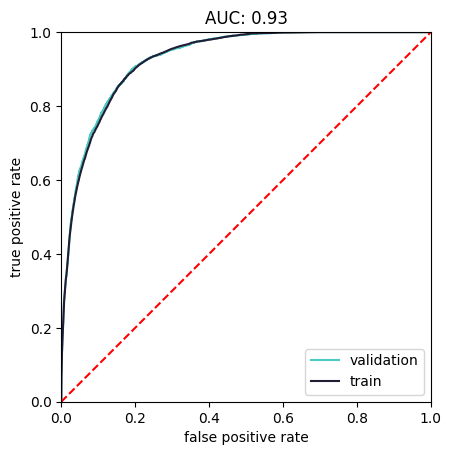

In [6]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": rf_process_config,
                        "train": {
                            "classifier": "RandomForestClassifier",
                            "n_estimators": 256,
                            "criterion": 'gini',
                            "min_weight_fraction_leaf": 0.01,
                            "max_features": "sqrt"
                        },
                        "experiment_name": "RF_v0.0.1"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.87      0.92     37523
           1       0.30      0.86      0.44      2422

    accuracy                           0.87     39945
   macro avg       0.64      0.86      0.68     39945
weighted avg       0.95      0.87      0.90     39945

AUC score: 0.94


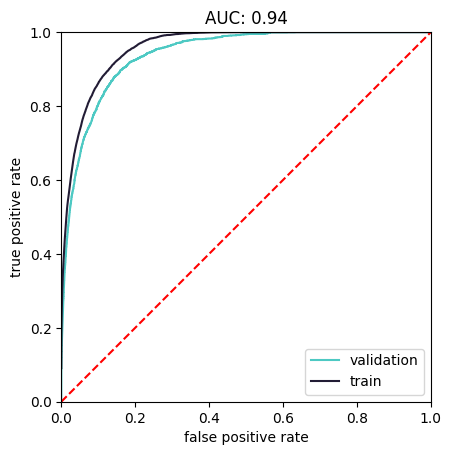

In [7]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": rf_process_config,
                        "train": {
                            "classifier": "RandomForestClassifier",
                            "n_estimators": 256,
                            "criterion": 'gini',
                            "min_weight_fraction_leaf": 0.0001,
                            "max_features": "sqrt"
                        },
                        "experiment_name": "RF_v0.0.2"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37523
           1       0.30      0.86      0.44      2422

    accuracy                           0.87     39945
   macro avg       0.64      0.86      0.68     39945
weighted avg       0.95      0.87      0.90     39945

AUC score: 0.941


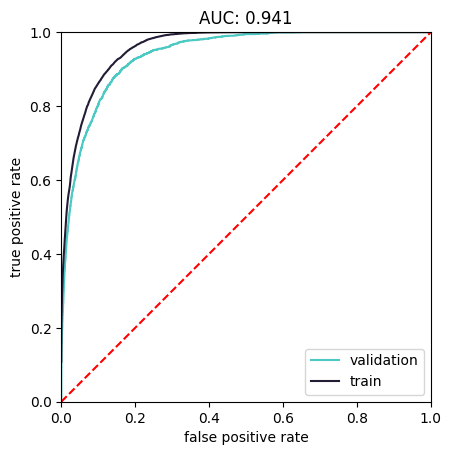

In [8]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": rf_process_config,
                        "train": {
                            "classifier": "RandomForestClassifier",
                            "n_estimators": 256,
                            "criterion": 'entropy',  #changed
                            "min_weight_fraction_leaf": 0.0001,
                            "max_features": "sqrt"
                        },
                        "experiment_name": "RF_v0.0.3"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37523
           1       0.30      0.86      0.44      2422

    accuracy                           0.87     39945
   macro avg       0.64      0.86      0.68     39945
weighted avg       0.95      0.87      0.90     39945

AUC score: 0.941


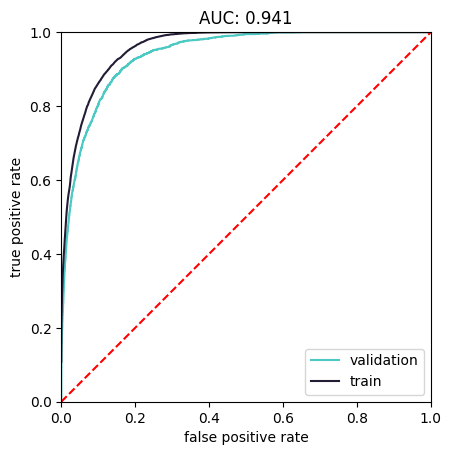

In [9]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": rf_process_config,
                        "train": {
                            "classifier": "RandomForestClassifier",
                            "n_estimators": 256,
                            "criterion": 'log_loss',  # changed again
                            "min_weight_fraction_leaf": 0.0001,
                            "max_features": "sqrt"
                        },
                        "experiment_name": "RF_v0.0.4"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

### Starting to overfit a little here, but validation AUC still going up. We're still erring on the side of predicting that someone earns more than they do

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     93576
           1       0.30      0.86      0.45      6186

    accuracy                           0.87     99762
   macro avg       0.65      0.86      0.69     99762
weighted avg       0.95      0.87      0.90     99762

Test AUC score: 0.941


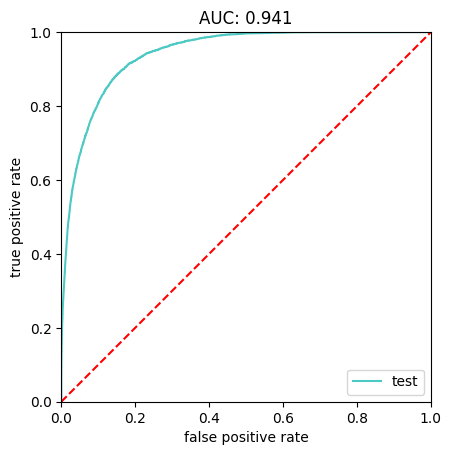

In [10]:
trainer.evaluate_on_unseen_dataset(df_test)

# Tiny bit better, but essentially the same

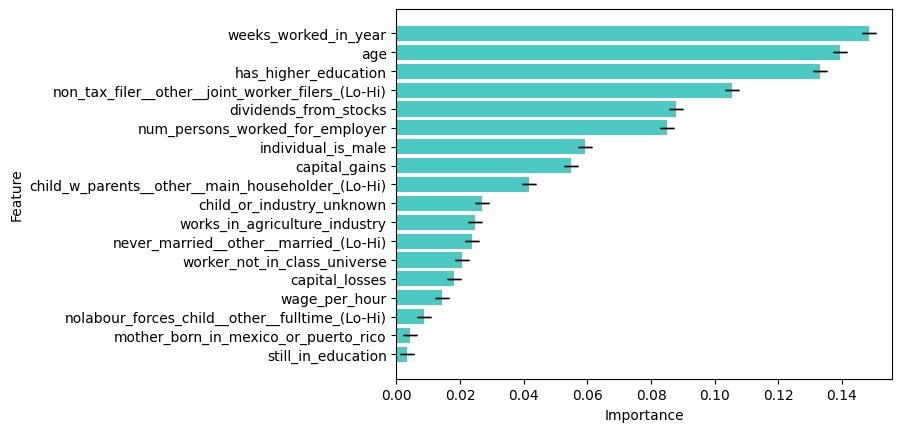

In [11]:
trainer.get_feature_importances()

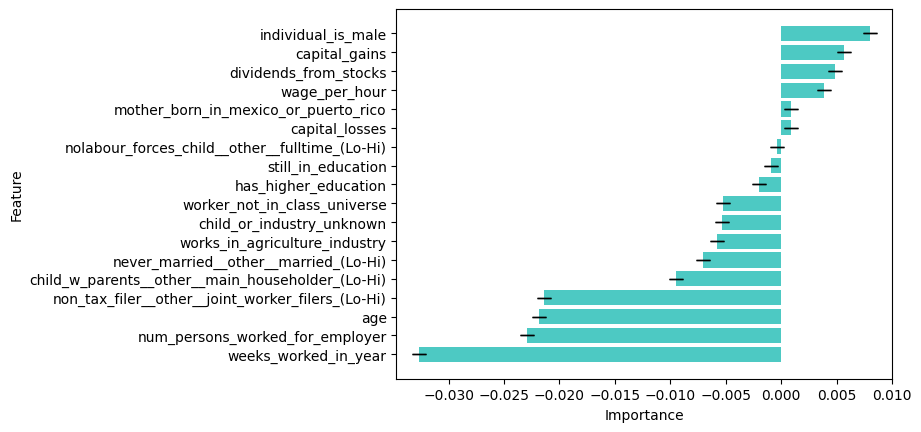

In [12]:
trainer.get_permutation_feature_importances()

Worth noting: https://scikit-learn.org/stable/modules/permutation_importance.html#misleading-values-on-strongly-correlated-features

Again, permutation importance being a little tricky. Ugh, give me SHAP, pleeaase

### I need to stop now... could do this forever. Some thoughts:
- I generally like RF's, and in particular combined with Shap; a next step would be to better understand the <i>direction</i> in which various features drive the score classification
- Useful to explain the "why" better to your audience. E.g. with age, is it really the middle-vs-ends that is driving the performance?
- Analysis on what the main drivers are for the negatives -- try to better engineer the features maybe
- So many more things to try with features. Haven't even played around with OHE
- That said, as with most of these scenarios, it really is the continuous numerical features coming up top -- they just have so much more versatility for slicing